# 주식 가격 예측 모델 개발

In [4]:
import gc
import os
import sys

from datetime import datetime
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf


from tqdm import tqdm

In [5]:
import pickle
with open("X_data.pkl", "rb") as f:
    X = pickle.load(f)
    
with open("Y_data.pkl", "rb") as f:
    Y = pickle.load(f)

In [6]:
data_path = Path.cwd().parent / "data"
stock_data_path = data_path / "stock_data"
image_file_path = data_path / "stock_chart_image"

## 데이터 수집 & 정제

### 코스피 시총 상위 주식 데이터 불러오기 & 저장

In [7]:
stock_code_dict = {
    "005930": "삼성",
    "000660": "SK하이닉스",
    "035420": "NAVER",
    "005380": "현대차",
    "035720": "카카오",
    "051910": "LG화학",
    "105560": "KB금융",
    "005490": "POSCO홀딩스",
    "055550": "신한지주",
    "003550": "LG"
}

In [8]:
yf.pdr_override()

for stock_code, name in tqdm(stock_code_dict.items()):
    stock_df = pdr.get_data_yahoo(f"{stock_code}.KS", "2012-05-01", "2022-05-01")
    
    #인덱스에 할당된 날짜 데이터를 컬럼으로 이동
    stock_df.reset_index(inplace=True)
    
    #이동평균선 생성을 위한 데이터 생성
    stock_df["ma_5"] = stock_df["Close"].rolling(5, 1).mean()
    stock_df["ma_20"] = stock_df["Close"].rolling(20, 1).mean()
    stock_df["ma_60"] = stock_df["Close"].rolling(60, 1).mean()
    # stock_df["ma_120"] = stock_df["Close"].rolling(120, 1).mean()
    # stock_df["ma_240"] = stock_df["Close"].rolling(240, 1).mean()
    
    #csv파일로 저장
    stock_df.to_csv(stock_data_path / f"{name}_{stock_code}.csv", index=False, encoding="utf-8")

 10%|████████▍                                                                           | 1/10 [00:03<00:28,  3.16s/it]


KeyboardInterrupt: 

In [32]:
if ([True, False, True]):
    print(1)

1


In [55]:
stock_df[["Open", "High", "Low", "Close"]].to_numpy()

array([[28200., 28360., 27980., 28200.],
       [28040., 28200., 27960., 28020.],
       [27500., 27960., 26980., 27200.],
       ...,
       [65400., 65500., 64900., 65000.],
       [65400., 65500., 64500., 64800.],
       [65100., 67600., 65000., 67400.]])

In [54]:
if (np.asarray(stock_df[["Open", "High", "Low", "Close"]][-3:]) == np.asarray(stock_df[["Open", "High", "Low", "Close"]][-2:-1])).all():
    print(1)

In [78]:
(stock_df.Volume.apply(lambda x: True if x == 0 else False))

0       False
1       False
2       False
3       False
4       False
        ...  
2454    False
2455    False
2456    False
2457    False
2458    False
Name: Volume, Length: 2459, dtype: bool

In [36]:
stock_df[["Open", "High", "Low", "Close"]][-3:-1] == stock_df[["Open", "High", "Low", "Close"]][-2:]

ValueError: Can only compare identically-labeled DataFrame objects

In [35]:
stock_df[["Open", "High", "Low", "Close"]][-2:]

,Open,High,Low,Close
2457,65400.0,65500.0,64500.0,64800.0
2458,65100.0,67600.0,65000.0,67400.0


In [33]:
stock_df[["Open", "High", "Low", "Close"]][-3:].apply(lambda x: (x == list(x)[0]))

,Open,High,Low,Close
2456,True,True,True,True
2457,True,True,False,False
2458,False,False,False,False


### 주식 차트 이미지 생성

- 각 차트 이미지 별로 20일치 거래 데이터를 포함한다.
- 해당 이미지의 마지막 일자를 기준으로 5일 뒤 가격을 보고 레이블링한다.
    - 5% 이상 하락 -> 하락 (1)
    - 5% 이상 상승 -> 상승 (2)
    - 가격변화의 절댓값이 5% 미만 -> 보합 (0)

In [32]:
def label_data(df:pd.DataFrame, 
               row_num: int,
               days: int,
               percentage: float):
    if df["Close"][row_num] * (1 - percentage) >= df["Close"][row_num + 5]:
        # Consider as decrease in price
        return 1
    elif df["Close"][row_num] * (1 + percentage) <= df["Close"][row_num + 5]:
        # Consider as increase in price
        return 2
    else:
        # Consider as no change in price
        return 0

In [103]:
def save_chart_image(df:pd.DataFrame, 
                     save_path: Path,
                     file_prefix: str,
                     window=20):
    edge_color = mpf.make_marketcolors(up="g", down="r", wick="inherit", volume="inherit")
    customstyle = mpf.make_mpf_style(base_mpf_style='yahoo', figcolor="black", marketcolors=edge_color)
    width_config={"candle_linewidth":3, 
                  "candle_width":1, 
                  "volume_width": 0.8}
                     
    for i in tqdm(range(len(df) - window - 5), desc=f"Data {file_prefix}"):
        target_df = df[i: i + window]
        label = label_data(df, i + window - 1, 5, 0.04)
        
        ma_5 = mpf.make_addplot(target_df.ma_5, width=2)
        ma_20 = mpf.make_addplot(target_df.ma_20, width=2)
        ma_60 = mpf.make_addplot(target_df.ma_60, width=2)
        
        file_path = save_path / f"{file_prefix}_{i}_{label}.jpg"
        
        try:
        fig, axlist = mpf.plot(target_df, 
                               type="candle",
                               style=customstyle, 
                               addplot=[ma_5, ma_20, ma_60],
                               update_width_config=width_config, 
                               figsize=(10, 10),
                               fontscale=0,
                               axisoff=True,
                               volume=True,
                               tight_layout=True,
                               returnfig=True,
                               closefig=True)
        except UserWarning:
            # 간혹 OHLC 모두 같은 값을 가져 그래프가 그려지지 않는 경우가 있는데 그런 경우, 그래프 생성 X
            continue
            
        fig.savefig(file_path)
        del(fig, axlist)

In [104]:
matplotlib.use("agg")
for stock_code, name in stock_code_dict.items():
    stock_df = pd.read_csv(stock_data_path / f"{name}_{stock_code}.csv", encoding="utf-8")
    stock_df["Date"] = stock_df["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    stock_df.set_index("Date", inplace=True, drop=True)
        
    if not os.path.isdir(image_file_path):
        os.mkdir(image_file_path)
    
    save_chart_image(stock_df, image_file_path, f"{name}_{stock_code}", 20)

Data NAVER_035420:  13%|███████▊                                                     | 310/2434 [00:23<03:09, 11.23it/s]/mnt/c/Users/Kyle/pythonProjects/StockPrediction/venv/lib/python3.8/site-packages/mplfinance/plotting.py:628: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/mnt/c/Users/Kyle/pythonProjects/StockPrediction/venv/lib/python3.8/site-packages/mplfinance/plotting.py:628: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
Data LG_003550: 100%|███████████████████████████████████████████████████████████████| 2434/2434 [03:10<00:00, 12.77it/s]


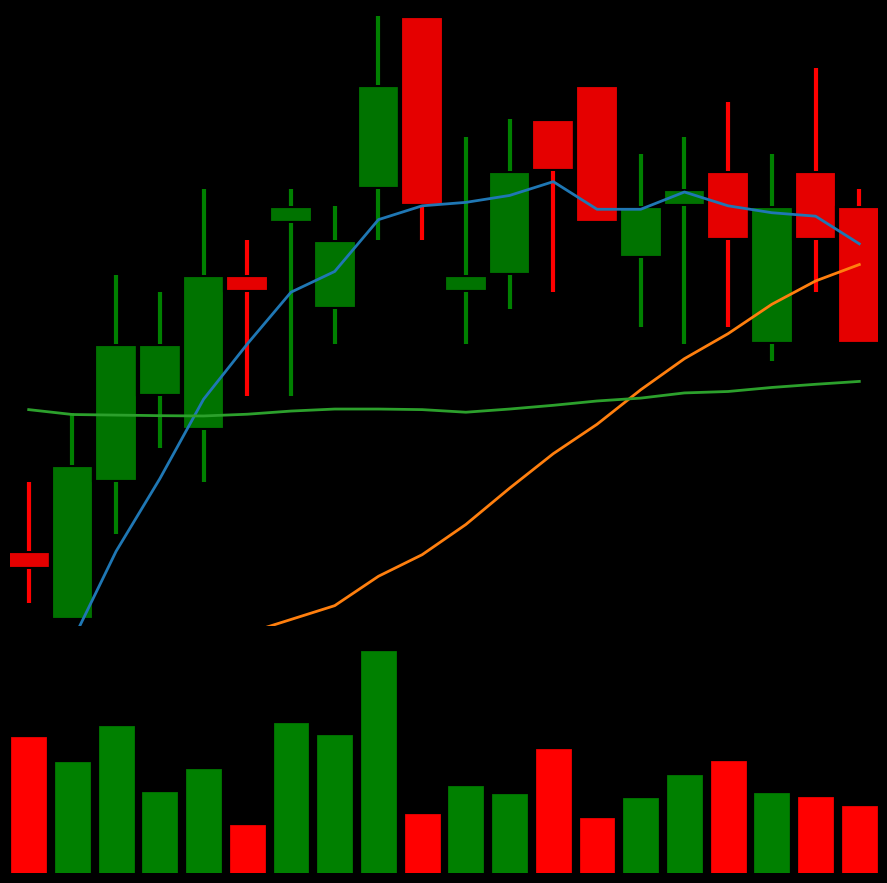

In [102]:
edge_color = mpf.make_marketcolors(up="g", down="r", wick="inherit", volume="inherit")
customstyle = mpf.make_mpf_style(base_mpf_style='yahoo', figcolor="black", marketcolors=edge_color)

width_config={"candle_linewidth":3, 
              "candle_width":1, 
              "volume_width": 0.8}

target_df = stock_df[200: 220]
ma_5 = mpf.make_addplot(target_df.ma_5, width=2)
ma_20 = mpf.make_addplot(target_df.ma_20, width=2)
ma_60 = mpf.make_addplot(target_df.ma_60, width=2)

mpf.plot(target_df, type="candle",
         style=customstyle, 
         addplot=[ma_5, ma_20, ma_60],
         update_width_config=width_config, 
         figsize=(10, 10),
         fontscale=0,
         axisoff=True,
         volume=True,
         tight_layout=True)

In [50]:
# for data in os.listdir(stock_data_path)[:10]:
#     stock_df = pd.read_csv(stock_data_path / data, encoding="utf-8")
#     stock_df = stock_df[stock_df.columns[1:]]
#     stock_df.rename(columns={"date": "Date", 
#                              "open": "Open", 
#                              "high": "High", 
#                              "low": "Low", 
#                              "close": "Close", 
#                              "volume": "Volume"},
#                     inplace=True)
#     stock_df["Date"] = stock_df["Date"].apply(lambda x: datetime.strptime(str(x), "%Y%m%d"))
#     stock_df.set_index("Date", inplace=True, drop=True)
    
#     file_prefix = data.split(".")[0]
    
#     if not os.path.isdir(image_file_path):
#         os.mkdir(image_file_path)
    
#     save_chart_image(stock_df, image_file_path, file_prefix)